# Modeling and Simulation in Python

Chapter 8

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [31]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Functions from the previous chapter

In [32]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [33]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

### Reading the data

In [34]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

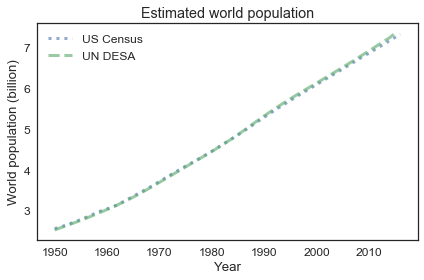

In [35]:
un = table2.un / 1e9
census = table2.census / 1e9
plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
    
decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title='Estimated world population')

### Running the quadratic model

Here's the update function for the quadratic growth model with parameters `alpha` and `beta`.

In [36]:
def update_func_quad(pop, t, system):
    """Update population based on a quadratic model.
    
    pop: current population in billions
    t: what year it is
    system: system object with model parameters
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

Extract the starting time and population.

In [37]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = get_first_value(census)

2.557628654

Initialize the system object.

In [38]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
alpha,0.025000
beta,-0.001800


Run the model and plot results.

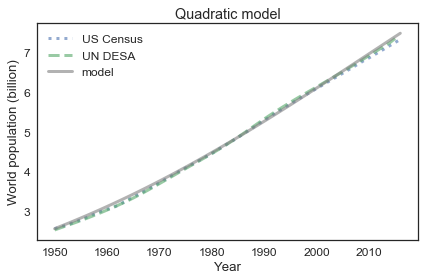

In [39]:
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')

### Generating projections

To generate projections, all we have to do is change `t_end`

Saving figure to file figs/chap04-fig01.pdf


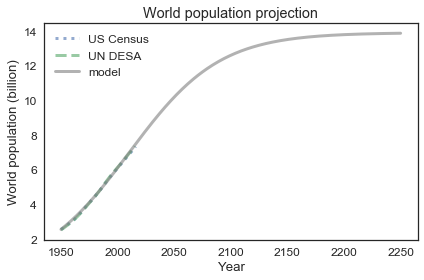

In [40]:
system.t_end = 2250
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'World population projection')
savefig('figs/chap04-fig01.pdf')

The population in the model converges on the equilibrium population, `-alpha/beta`

In [41]:
results[system.t_end]

13.856665141368708

In [42]:
-system.alpha / system.beta

13.88888888888889

**Exercise:**  What happens if we start with an initial population above the carrying capacity, like 20 billion?  Run the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

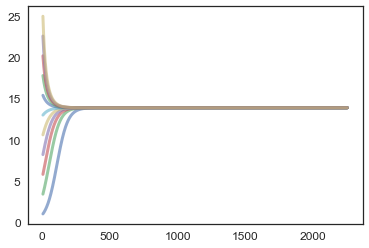

In [30]:
p0_array=linspace(1,25,11)

for system.p_0 in p0_array:
    results = run_simulation(system, update_func_quad)
    plot(results)

### Comparing projections

We can compare the projection from our model with projections produced by people who know what they are doing.

In [14]:
table3 = tables[3]
table3.head()

`NaN` is a special value that represents missing data, in this case because some agencies did not publish projections for some years.

In [15]:
table3.columns = ['census', 'prb', 'un']

This function plots projections from the UN DESA and U.S. Census.  It uses `dropna` to remove the `NaN` values from each series before plotting it.

In [16]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census / 1e9
    un_proj = table.un / 1e9
    
    plot(census_proj.dropna(), 'b:', label='US Census')
    plot(un_proj.dropna(), 'g--', label='UN DESA')

Run the model until 2100, which is as far as the other projections go.

In [17]:
system = System(t_0=t_0, 
                t_end=2100,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

In [18]:
results = run_simulation(system, update_func_quad)

plot_results(census, un, results, 'World population projections')
plot_projections(table3)
savefig('figs/chap04-fig02.pdf')

People who know what they are doing expect the growth rate to decline more sharply than our model projects.

## Exercises

**Optional exercise:** The net growth rate of world population has been declining for several decades.  That observation suggests one more way to generate projections, by extrapolating observed changes in growth rate.

The `modsim` library provides a function, `compute_rel_diff`, that computes relative differences of the elements in a sequence.  It is a wrapper for the NumPy function `ediff1d`:

In [19]:
%psource compute_rel_diff

Here's how we can use it to compute the relative differences in the `census` and `un` estimates:

In [20]:
alpha_census = compute_rel_diff(census)
plot(alpha_census)

alpha_un = compute_rel_diff(un)
plot(alpha_un)

decorate(xlabel='Year', label='Net growth rate')

Other than a bump around 1990, net growth rate has been declining roughly linearly since 1965.  As an exercise, you can use this data to make a projection of world population until 2100.

1. Define a function, `alpha_func`, that takes `t` as a parameter and returns an estimate of the net growth rate at time `t`, based on a linear function `alpha = intercept + slope * t`.  Choose values of `slope` and `intercept` to fit the observed net growth rates since 1965.

2. Call your function with a range of `ts` from 1960 to 2020 and plot the results.

3. Create a `System` object that includes `alpha_func` as a system variable.

4. Define an update function that uses `alpha_func` to compute the net growth rate at the given time `t`.

5. Test your update function with `t_0 = 1960` and `p_0 = census[t_0]`.

6. Run a simulation from 1960 to 2100 with your update function, and plot the results.

7. Compare your projections with those from the US Census and UN.

In [21]:
# Solution goes here

In [22]:
# Solution goes here

In [23]:
# Solution goes here

In [24]:
# Solution goes here

In [25]:
# Solution goes here

In [26]:
# Solution goes here

In [27]:
# Solution goes here

In [28]:
# Solution goes here

**Related viewing:** You might be interested in this [video by Hans Rosling about the demographic changes we expect in this century](https://www.youtube.com/watch?v=ezVk1ahRF78).